# 1. Ładujemy dane do DataFrame Pandasa i wybieramy kolumny do zbiorów X i Y

In [3]:
import pandas as pd

train_dataset = pd.read_csv("data/train.csv")
test_x = pd.read_csv("data/test.csv")
X_test = test_x[['id', 'comment_text']]
test_y = pd.read_csv("data/test_labels.csv")
y_test = test_y[['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
y_test_filtered = y_test[~(y_test == -1).any(axis=1)]
X_test_filtered = X_test.merge(y_test_filtered[['id']], on='id')
test_dataset = pd.merge(X_test_filtered, y_test_filtered, on='id', how='inner')

dataset = pd.concat([train_dataset, test_dataset], axis=0)
dataset.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 2. Przeprowadzamy analizę EDA na naszym zbiorze danych

# 2.1 Dystrybucja kolumn

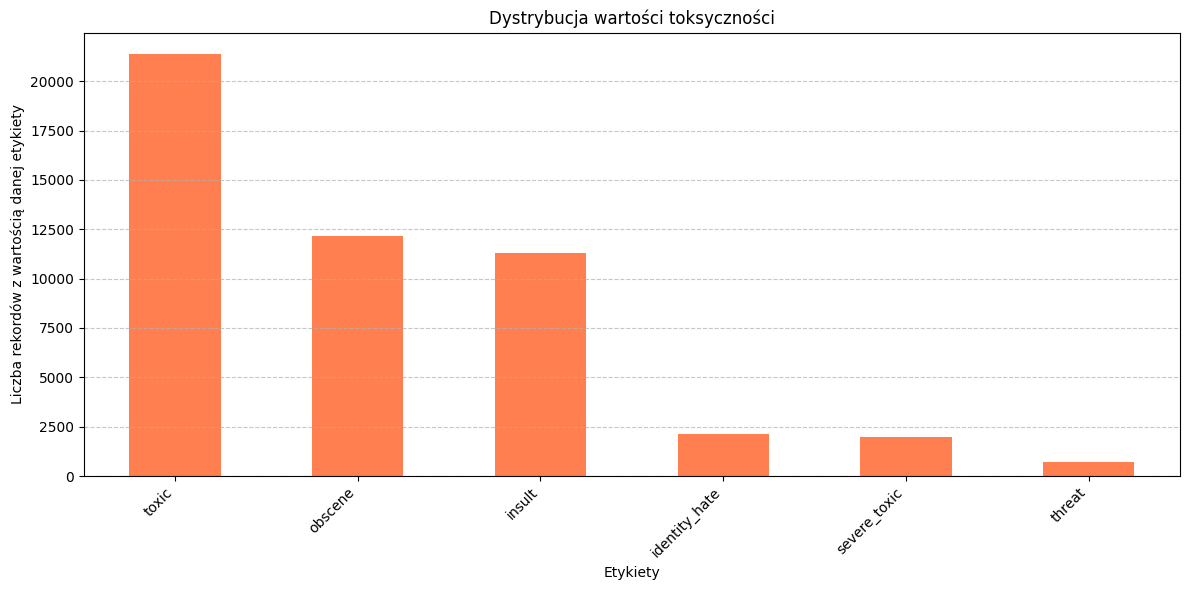

In [4]:
import matplotlib.pyplot as plt

label_cols = [col for col in dataset[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]]
label_counts = dataset[label_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='coral')
plt.title('Dystrybucja wartości toksyczności')
plt.xlabel('Etykiety')
plt.ylabel('Liczba rekordów z wartością danej etykiety')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2.2 Wordcloud


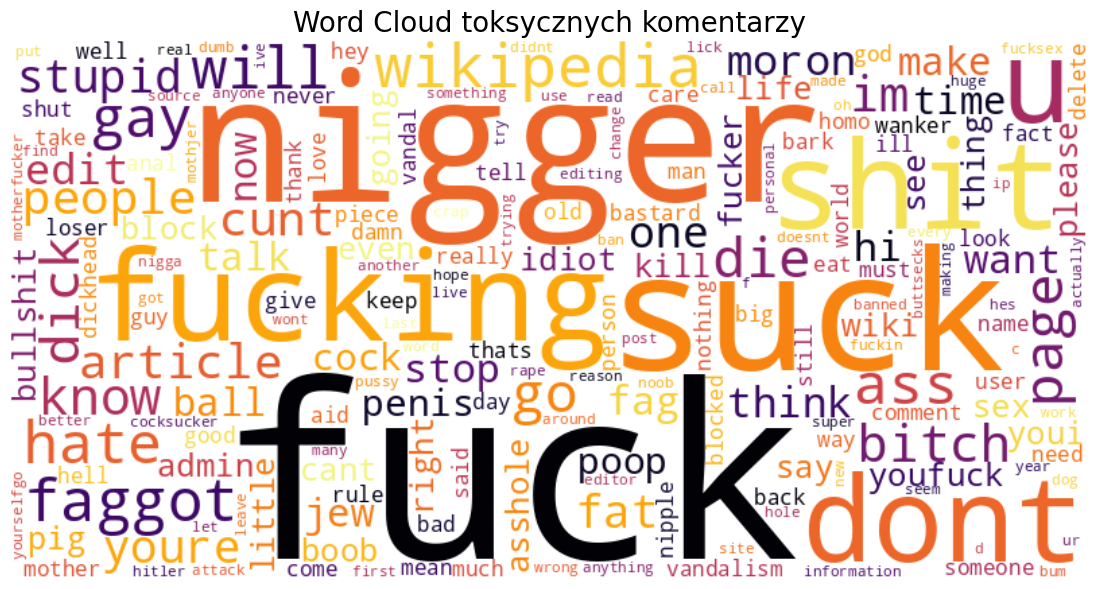

In [5]:
import re
from wordcloud import STOPWORDS, WordCloud

toxic_mask = dataset[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].any(axis=1)
toxic_comments = dataset[toxic_mask]['comment_text']

def preprocess(text):
    text = str(text).lower()  # lowercase
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation/numbers
    text = re.sub(r"\s+", " ", text)  # normalize whitespace
    return text

cleaned_text = toxic_comments.apply(preprocess)

full_text = " ".join(cleaned_text)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='inferno',
    max_words=200,
    stopwords=STOPWORDS,
    collocations=False 
).generate(full_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud toksycznych komentarzy", fontsize=20)
plt.show()

# 2.3 Korelacja etykiet toksyczności

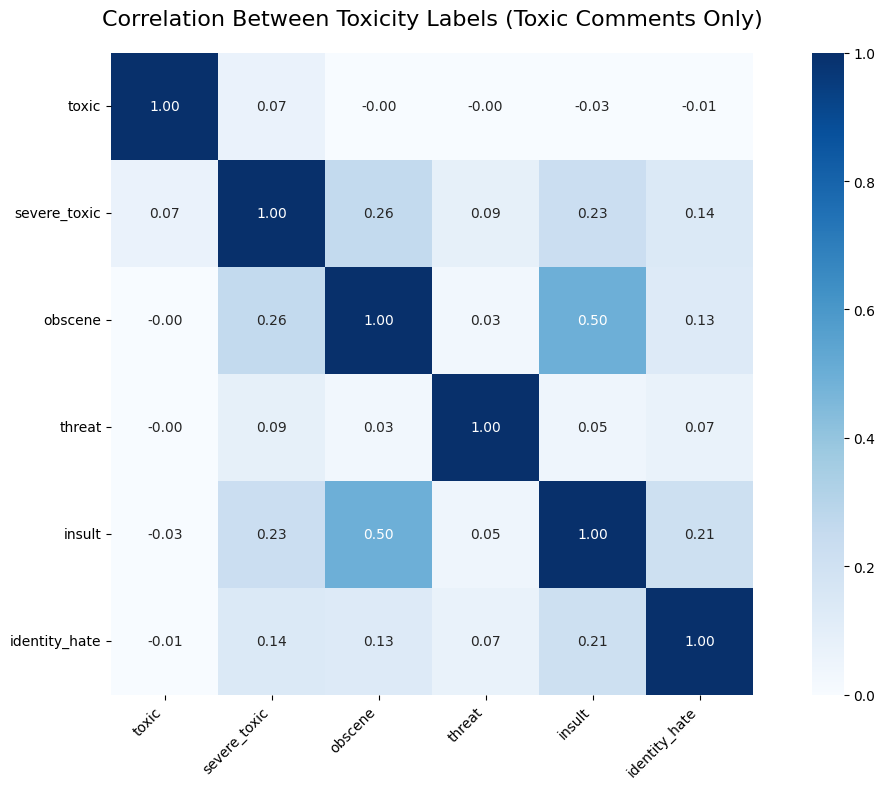

In [6]:
import seaborn as sns

label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
rowsums = dataset[label_columns].sum(axis=1)

toxic_subset = dataset[rowsums > 0]

corr_matrix = toxic_subset[label_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix,
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns,
            annot=True, fmt=".2f",
            cmap="Blues",
            vmin=0, vmax=1,
            square=True)
plt.title("Correlation Between Toxicity Labels (Toxic Comments Only)", pad=20, fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. Procesowanie tekstu

# 3.1 Filtrowanie kolumn 

In [7]:
dataset = dataset.drop(columns='id')

# 3.2 Oczyszczanie tekstu ze znaków specjalnych i na zmiana na małe litery

In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+|[^a-zA-Z\s]", "", text)
    text = re.sub(r'\n', ' ', text)
    return text 
dataset['comment_text'] = dataset['comment_text'].apply(clean_text) 
dataset.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation why the edits made under my userna...,0,0,0,0,0,0
1,daww he matches this background colour im seem...,0,0,0,0,0,0
2,hey man im really not trying to edit war its j...,0,0,0,0,0,0
3,more i cant make any real suggestions on impr...,0,0,0,0,0,0
4,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


# 3.3 Tokenizowanie tekstu

In [9]:
import nltk 
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word not in stop_words]
    return tokens
    
dataset['comment_text'] = dataset['comment_text'].apply(tokenize) 
dataset.head()

[nltk_data] Downloading package punkt_tab to /home/potus/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/potus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[explanation, edits, made, username, hardcore,...",0,0,0,0,0,0
1,"[daww, matches, background, colour, im, seemin...",0,0,0,0,0,0
2,"[hey, man, im, really, trying, edit, war, guy,...",0,0,0,0,0,0
3,"[cant, make, real, suggestions, improvement, w...",0,0,0,0,0,0
4,"[sir, hero, chance, remember, page, thats]",0,0,0,0,0,0


# 3.4 Lemmatyzacja tekstu

In [10]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmatized) 
dataset['comment_text'] = dataset['comment_text'].apply(lemmatize) 
dataset.head()

[nltk_data] Downloading package wordnet to /home/potus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,daww match background colour im seemingly stuc...,0,0,0,0,0,0
2,hey man im really trying edit war guy constant...,0,0,0,0,0,0
3,cant make real suggestion improvement wondered...,0,0,0,0,0,0
4,sir hero chance remember page thats,0,0,0,0,0,0


# 4.0 Wektoryzacja tekstu

# 4.1 TdfIdf Vectorizer

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000) 
tfidf_matrix = tfidf_vectorizer.fit_transform(dataset['comment_text'])

dataset_tfidf_X = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
dataset_tfidf_X.head()

,aa,abc,abide,ability,able,abortion,absence,absolute,absolutely,abstract,...,youth,youtube,youve,ytmndin,yugoslavia,zealand,zero,zeuphoris,zionist,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4.2 Word2Vec CBOW

In [12]:
import numpy as np
from gensim.models import Word2Vec

word2vec_model = Word2Vec(
    dataset['comment_text'],  
    vector_size=100,    
    window=5,          
    min_count=2,        
    workers=4,          
    epochs=10           
)

def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in word2vec_model.wv.key_to_index]
    if len(doc) == 0:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word2vec_model.wv[doc], axis=0)

word2vec_vectors = [document_vector(word2vec_model, doc) for doc in dataset['comment_text']]
dataset_word2vec_X = pd.DataFrame(word2vec_vectors)
dataset_word2vec_X.columns = [f"word2vec_{i}" for i in range(word2vec_model.vector_size)]

dataset_word2vec_X.head()

,word2vec_0,word2vec_1,word2vec_2,word2vec_3,word2vec_4,word2vec_5,word2vec_6,word2vec_7,word2vec_8,word2vec_9,...,word2vec_90,word2vec_91,word2vec_92,word2vec_93,word2vec_94,word2vec_95,word2vec_96,word2vec_97,word2vec_98,word2vec_99
0,-0.013783,-0.023021,0.001850,0.281884,0.027982,0.386205,0.171967,0.275877,-0.006174,0.127321,...,-0.220419,-0.040971,-0.061192,-0.191650,0.298232,0.009150,-0.116768,-0.081466,-0.010224,-0.218756
1,-0.167327,-0.150774,-0.121822,0.134751,-0.029201,0.274118,0.117476,0.193162,0.024274,-0.087183,...,0.062344,-0.057763,0.078854,-0.175693,0.107696,0.097169,-0.021660,0.004894,0.189830,-0.174307
2,-0.011244,0.003096,-0.001980,0.243178,-0.014041,0.330346,0.195025,0.208423,0.011873,0.129007,...,-0.093489,-0.053826,-0.025804,-0.160483,0.246632,0.042684,-0.167502,-0.107231,-0.000113,-0.252037
3,-0.015199,-0.041007,-0.035355,0.233637,-0.023783,0.366100,0.171414,0.296306,0.002532,0.117617,...,-0.167356,-0.058629,-0.040761,-0.208200,0.302218,0.020207,-0.095442,-0.062885,0.038129,-0.208680
4,-0.094192,-0.091657,-0.040313,0.275928,0.029191,0.383938,0.180637,0.137989,0.084819,-0.078480,...,-0.123996,-0.078247,-0.176685,-0.343007,0.328255,0.001893,-0.131745,0.044936,-0.137411,-0.382823


# 5. Podział danych na zbiór testowy i uczący

# 5.1 Podział TdfIdfVectorizer na 70/30

In [1]:
from sklearn.model_selection import train_test_split

y = dataset[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
X_tf_train_70, X_tf_test_30, y_tf_train_70, y_tf_test_30 = train_test_split(dataset_tfidf_X, y, test_size=0.3, random_state=42)

NameError: name 'dataset' is not defined

# 5.2 Podział TdfIdfVectorizer na 80/20

In [14]:
X_tf_train_80, X_tf_test_20, y_tf_train_80, y_tf_test_20 = train_test_split(dataset_tfidf_X, y, test_size=0.2, random_state=42)

# 5.3 Podział Word2Vec na 70/30

In [15]:
X_w2v_train_70, X_w2v_test_30, y_w2v_train_70, y_w2v_test_30 = train_test_split(dataset_word2vec_X, y, test_size=0.3, random_state=42)

# 5.4 Podział Word2Vec na 80/20

In [16]:
X_w2v_train_80, X_w2v_test_20, y_w2v_train_80, y_w2v_test_20 = train_test_split(dataset_word2vec_X, y, test_size=0.3, random_state=42)

# 6 Trenowanie modeli

# 6.1 Logistic Regression TdfIdfVectorizer 70/30

Precision (Macro) [TF-IDF 70/30]:   0.7302
Recall (Macro) [TF-IDF 70/30]:      0.3966
F1 Score (Macro) [TF-IDF 70/30]:    0.5001



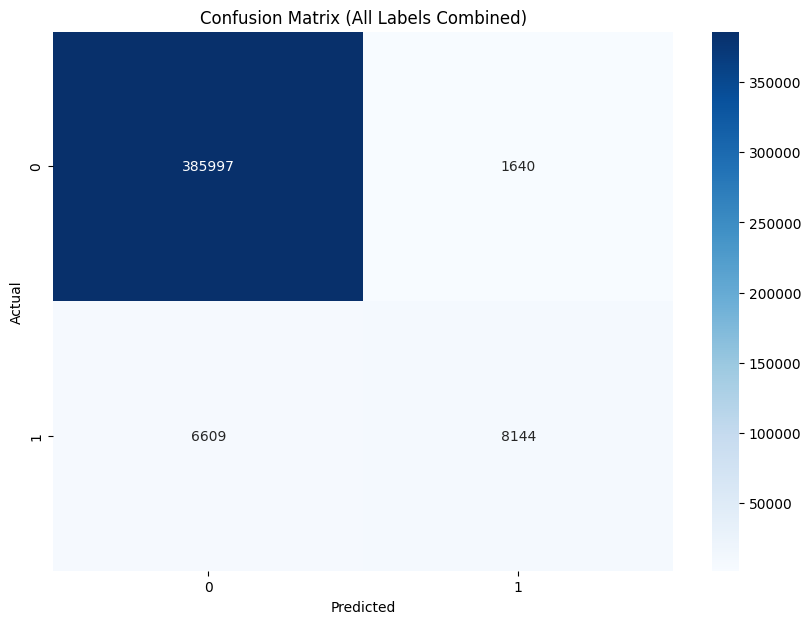

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

clf = OneVsRestClassifier(LogisticRegression(max_iter=1000, solver='liblinear'))
clf.fit(X_tf_train_70, y_tf_train_70)

y_pred_30 = clf.predict(X_tf_test_30)

precision_lr_tfidf_70_30 = precision_score(y_tf_test_30, y_pred_30, average='macro')
recall_lr_tfidf_70_30 = recall_score(y_tf_test_30, y_pred_30, average='macro')
f1_lr_tfidf_70_30 = f1_score(y_td_test_30, y_pred_30, average='macro')

print(f"Precision (Macro) [TF-IDF 70/30]:   {precision_lr_tfidf_70_30:.4f}")
print(f"Recall (Macro) [TF-IDF 70/30]:      {recall_lr_tfidf_70_30:.4f}")
print(f"F1 Score (Macro) [TF-IDF 70/30]:    {f1_lr_tfidf_70_30:.4f}\n")

cm = confusion_matrix(y_tf_test_30.values.flatten(), y_pred_30.flatten())

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (All Labels Combined)')
plt.show()

# 6.2 Logistic Regression TdfIdfVectorizer 80/20

In [22]:
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000, solver='liblinear'))
clf.fit(X_tf_train_80, y_tf_train_80)

y_pred_tf_20 = clf.predict(X_tdf_test_20)

precision_lr_tfidf_80_20 = precision_score(y_tf_test_20, y_pred_tf_20, average='macro')
recall_lr_tdfif_80_20 = recall_score(y_tf_test_20, y_pred_tf_20, average='macro')
f1_lr_tfidf_80_20 = f1_score(y_tf_test_20, y_pred_tf_20, average='macro')

print(f"Precision (Macro) [TF-IDF 80/20]:   {precision_lr_tfidf_80_20:.4f}")
print(f"Recall (Macro)    [TF-IDF 80/20]:   {recall_lr_tfidf_80_20:.4f}")
print(f"F1 Score (Macro)  [TF-IDF 80/20]:   {f1_lr_tfidf_80_20:.4f}")

Precision (Macro) [TF-IDF 80/20]:   0.7062
Recall (Macro)    [TF-IDF 80/20]:   0.3962
F1 Score (Macro)  [TF-IDF 80/20]:   0.4959


# 6.3 Logistic Regression Word2Vec 70/30

In [25]:
clf_w2v_70 = OneVsRestClassifier(LogisticRegression(max_iter=1000, solver='liblinear'))
clf_w2v_70.fit(X_w2v_train_70, y_w2v_train_70)

y_pred_w2v_30 = clf_w2v_70.predict(X_w2v_test_30)

precision_w2v_70_30 = precision_score(y_w2v_test_30, y_pred_w2v_30, average='macro')
recall_w2v_70_30 = recall_score(y_w2v_test_30, y_pred_w2v_30, average='macro')
f1_w2v_70_30 = f1_score(y_w2v_test_30, y_pred_w2v_30, average='macro')

print(f"Precision (Macro) [W2V 70/30]:   {precision_w2v_70_30:.4f}")
print(f"Recall (Macro) [W2V 70/30]:      {recall_w2v_70_30:.4f}")
print(f"F1 Score (Macro) [W2V 70/30]:    {f1_w2v_70_30:.4f}")

Precision (Macro) [W2V 70/30]:   0.4486
Recall (Macro) [W2V 70/30]:      0.0712
F1 Score (Macro) [W2V 70/30]:    0.1211


# 6.4 Logistic Regression Word2Vec 80/20

In [26]:
clf_w2v_80 = OneVsRestClassifier(LogisticRegression(max_iter=1000, solver='liblinear'))
clf_w2v_80.fit(X_w2v_train_80, y_w2v_train_80)

y_pred_w2v_20 = clf_w2v_80.predict(X_w2v_test_20)

precision_lr_w2v_80_20 = precision_score(y_w2v_test_20, y_pred_w2v_20, average='macro')
recall_lr_w2v_80_20 = recall_score(y_w2v_test_20, y_pred_w2v_20, average='macro')
f1_lr_w2v_80_20 = f1_score(y_w2v_test_20, y_pred_w2v_20, average='macro')

print(f"Precision (Macro) [W2V 80/20]:   {precision_lr_w2v_80_20:.4f}")
print(f"Recall (Macro) [W2V 80/20]:      {recall_lr_w2v_80_20:.4f}")
print(f"F1 Score (Macro) [W2V 80/20]:    {f1_lr_w2v_80_20:.4f}")

Precision (Macro) [W2V 80/20]:   0.4486
Recall (Macro) [W2V 80/20]:      0.0712
F1 Score (Macro) [W2V 80/20]:    0.1211


# 6.5 LinearSVC TdfIdfVectorizer 70/30

In [28]:
from sklearn.svm import LinearSVC

clf_svc_tfidf_70 = OneVsRestClassifier(LinearSVC(max_iter=1000))
clf_svc_tfidf_70.fit(X_tdf_train_70, y_tdf_train_70)

y_pred_svc_tfidf_30 = clf_svc_tfidf_70.predict(X_tdf_test_30)

precision_svc_tfidf_70_30 = precision_score(y_tdf_test_30, y_pred_svc_tfidf_30, average='macro')
recall_svc_tfidf_70_30 = recall_score(y_tdf_test_30, y_pred_svc_tfidf_30, average='macro')
f1_svc_tfidf_70_30 = f1_score(y_tdf_test_30, y_pred_svc_tfidf_30, average='macro')

print(f"Precision (Macro) [LSVC TDF 70/30]: {precision_svc_tfidf_70_30:.4f}")
print(f"Recall (Macro) [LSVC TDF 70/30]: {recall_svc_tfidf_70_30:.4f}")
print(f"F1 Score (Macro) [LSVC TDF 70/30]: {f1_svc_tfidf_70_30:.4f}")

Precision (Macro) [LSVC TDF 70/30]: 0.7127
Recall (Macro) [LSVC TDF 70/30]: 0.4271
F1 Score (Macro) [LSVC TDF 70/30]: 0.5225


# 6.6 Linearsvc TdfIdfVectorizer 80/20

In [29]:
clf_svc_tfidf_80 = OneVsRestClassifier(LinearSVC(max_iter=1000))
clf_svc_tfidf_80.fit(X_tdf_train_80, y_tdf_train_80)

y_pred_svc_tfidf_20 = clf_svc_tfidf_80.predict(X_tdf_test_20)

precision_svc_tfidf_80_20 = precision_score(y_tdf_test_20, y_pred_svc_tfidf_20, average='macro')
recall_svc_tfidf_80_20 = recall_score(y_tdf_test_20, y_pred_svc_tfidf_20, average='macro')
f1_svc_tfidf_80_20 = f1_score(y_tdf_test_20, y_pred_svc_tfidf_20, average='macro')

print(f"Precision (Macro) [LSVC TDF 80/20]: {precision_svc_tfidf_80_20:.4f}")
print(f"Recall (Macro) [LSVC TDF 80/20]: {recall_svc_tfidf_80_20:.4f}")
print(f"F1 Score (Macro) [LSVC TDF 80/20]: {f1_svc_tfidf_80_20:.4f}")


Precision (Macro):   0.7139
Recall (Macro):      0.4256
F1 Score (Macro):    0.5210


# 6.7 LinearSVC Word2Vec 70/30

In [30]:
clf_svc_w2v_70 = OneVsRestClassifier(LinearSVC(max_iter=1000))
clf_svc_w2v_70.fit(X_w2v_train_70, y_w2v_train_70)

y_pred_svc_w2v_30 = clf_svc_w2v_70.predict(X_w2v_test_30)

precision_svc_w2v_70_30 = precision_score(y_w2v_test_30, y_pred_svc_w2v_30, average='macro')
recall_svc_w2v_70_30 = recall_score(y_w2v_test_30, y_pred_svc_w2v_30, average='macro')
f1_svc_w2v_70_30 = f1_score(y_w2v_test_30, y_pred_svc_w2v_30, average='macro')

print(f"Precision (Macro) [LSVC W2V 70/30]: {precision_svc_w2v_70_30:.4f}")
print(f"Recall (Macro) [LSVC W2V 70/30]: {recall_svc_w2v_70_30:.4f}")
print(f"F1 Score (Macro) [LSVC W2V 70/30]: {f1_svc_w2v_70_30:.4f}")

Precision (Macro) [LSVC W2V 70/30]: 0.4110
Recall (Macro) [LSVC W2V 70/30]: 0.0329
F1 Score (Macro) [LSVC W2V 70/30]: 0.0605


/home/potus/mlraportnr2/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 6.8 LinearSVC Word2Vec 80/20

In [31]:
clf_svc_w2v_80 = OneVsRestClassifier(LinearSVC(max_iter=1000))
clf_svc_w2v_80.fit(X_w2v_train_80, y_w2v_train_80)

y_pred_svc_w2v_20 = clf_svc_w2v_80.predict(X_w2v_test_20)

precision_svc_w2v_80_20 = precision_score(y_w2v_test_20, y_pred_svc_w2v_20, average='macro')
recall_svc_w2v_80_20 = recall_score(y_w2v_test_20, y_pred_svc_w2v_20, average='macro')
f1_svc_w2v_80_20 = f1_score(y_w2v_test_20, y_pred_svc_w2v_20, average='macro')

print(f"Precision (Macro) [LSVC W2V 80/20]:   {precision_svc_w2v_80_20:.4f}")
print(f"Recall (Macro) [LSVC W2V 80/20]:      {recall_svc_w2v_80_20:.4f}")
print(f"F1 Score (Macro) [LSVC W2V 80/20]:    {f1_svc_w2v_80_20:.4f}")

Precision (Macro) [LSVC W2V 80/20]:   0.4110
Recall (Macro) [LSVC W2V 80/20]:      0.0329
F1 Score (Macro) [LSVC W2V 80/20]:    0.0605


/home/potus/mlraportnr2/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 7.0 Podsumowanie

In [41]:
!pip install tabulate
from tabulate import tabulate

results = [
    {
        "Model": "Logistic Regression",
        "Vectorizer": "TF-IDF",
        "Split": "70/30",
        "Precision": precision_lr_tdfidf_70_30,
        "Recall": recall_lr_tdfidf_70_30,
        "F1": f1_lr_tdfidf_70_30
    },
    {
        "Model": "Logistic Regression",
        "Vectorizer": "TF-IDF",
        "Split": "80/20",
        "Precision": precision_lr_tdfidf_80_20,
        "Recall": recall_lr_tdfidf_80_20,
        "F1": f1_lr_tdfidf_80_20
    },
    {
        "Model": "Logistic Regression",
        "Vectorizer": "Word2Vec",
        "Split": "70/30",
        "Precision": precision_lr_w2v_70_30,
        "Recall": recall_lr_w2v_70_30,
        "F1": f1_lr_w2v_70_30
    },
    {
        "Model": "Logistic Regression",
        "Vectorizer": "Word2Vec",
        "Split": "80/20",
        "Precision": precision_lr_w2v_80_20,
        "Recall": recall_lr_w2v_80_20,
        "F1": f1_lr_w2v_80_20
    },
    {
        "Model": "SVM",
        "Vectorizer": "TF-IDF",
        "Split": "70/30",
        "Precision": precision_svc_tdfidf_70_30,
        "Recall": recall_svc_tdfidf_70_30,
        "F1": f1_svc_tdfidf_70_30
    },
    {
        "Model": "SVM",
        "Vectorizer": "TF-IDF",
        "Split": "80/20",
        "Precision": precision_svc_tdfidf_80_20,
        "Recall": recall_svc_tdfidf_80_20,
        "F1": f1_svc_tdfidf_80_20
    },
    {
        "Model": "SVM",
        "Vectorizer": "Word2Vec",
        "Split": "70/30",
        "Precision": precision_svc_w2v_70_30,
        "Recall": recall_svc_w2v_70_30,
        "F1": f1_svc_w2v_70_30
    },
    {
        "Model": "SVM",
        "Vectorizer": "Word2Vec",
        "Split": "80/20",
        "Precision": precision_svc_w2v_80_20,
        "Recall": recall_svc_w2v_80_20,
        "F1": f1_svc_w2v_80_20
    }
]

df = pd.DataFrame(results)
print(tabulate(df, headers='keys', tablefmt='grid', showindex=False, floatfmt=".4f"))

NameError: name 'precision_lr_w2v_70_30' is not defined